# Load in dataset

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load data and get a quick look
fp = "data.csv"
df = pd.read_csv(fp)
display(df.head(10))

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


# Data Cleaning
Here I will check for any missing values, duplications, etc...

In [3]:
nData = df.shape[0]
# Check for any missing values
dictionary = {'NumMissingValues':df.isna().sum(),'RatioMissingValues':df.isna().sum()/nData}
# display(df.isna().sum())
# display(df.isna().sum()/nData)
display(pd.DataFrame(dictionary))

,NumMissingValues,RatioMissingValues
id,0,0.0
diagnosis,0,0.0
radius_mean,0,0.0
texture_mean,0,0.0
perimeter_mean,0,0.0
area_mean,0,0.0
smoothness_mean,0,0.0
compactness_mean,0,0.0
concavity_mean,0,0.0
concave points_mean,0,0.0


So no missing values apart from a column `Unnamed: 32` which are all NaN. Meaning they can be dropped

In [4]:
# Drop the unnamed:32 column
df = df.drop(labels="Unnamed: 32", axis=1)
#Print to confirm it is removed
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [5]:
#Any duplicates?
nVals = df.shape[0]
nUniqueId = len(df['id'].unique())
print(nUniqueId, nVals)

569 569


No duplicated `id` values so unlikely for the data to be duplicated in its entirety

# Exploratory Data Analysis
The plan is to...
1. Look for class imbalance, which will help determine which scoring metric to use to evaluate the data.

2. Look at the different distributions and see if...
    1. Normalisations or other transformations are necessary?
    2. Are there any anomalous values which I will need to impute?
    3. Even within a single class metric are there any clear differences between the two sets of data.
    
3. For visualisation purposes will dimension reduction help shed any light, produce any clear differences? I will assess unsupervised and supervised dimension reduction techniques.
    1. For unsupervised reduction: First I will try PCA and if that doesn't work I will try UMAP
        1. **PCA**: PCA is unbiassed and tries to reduce the variance into new putative dimensions known as principal components. If successful these components can even be used as features.
        2. **UMAP**:If PCA doesn't work effectively, a final strategy is to use UMAP which uses local neighbours to create a manifold in the specified dimenision. NB this manifold is not linear or scalable. So it is not advised to utilise this method if performing subsequent clustering analysis.
        
    2. For supervised techniques: I will consider two methods Partial Least Squares (PLS), and also Fisher's Discriminant Analysis.
       1. **PLS**: Without going into a lot of details PLS utilises matrix multiplication to multiply the input matrix with a putative loading matrix (n_features by n_components) to produce values as similar as possible to the target variable. Essentially think of it a bit like linear regression with n components where each component has weighted contributions from all of our existing variables.
       2. **Fischers Discriminant Analysis**: Here this essentially attempts to reduce everything down to the minimum dimensions needed (e.g. if 2 classes, then one dimension, 4 classes = 3D, etc...) by working out the maximum distance of the centroids of the classes.

## Is there a class imbalance?

[Text(0, 0, '212'), Text(0, 0, '357')]

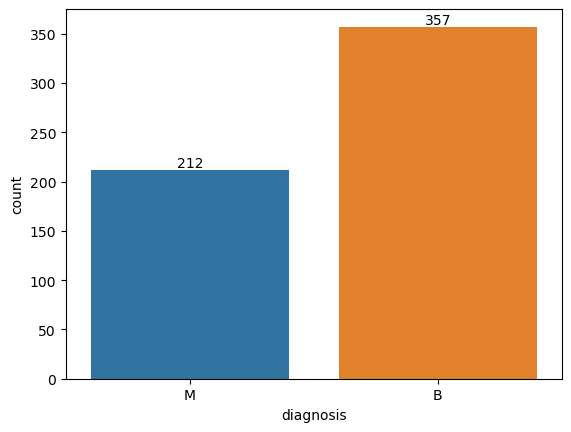

In [6]:
# Does the data set have a good split of malign and benign tumors?
ax = sns.countplot(data=df, x='diagnosis')
ax.bar_label(ax.containers[0])

There are approximately 150 more benign tumors. Which will mean I should use the F1 score when measuring accuracy as it is based on the harmonic mean.

## Looking at spreads and distributions of individual features/variables

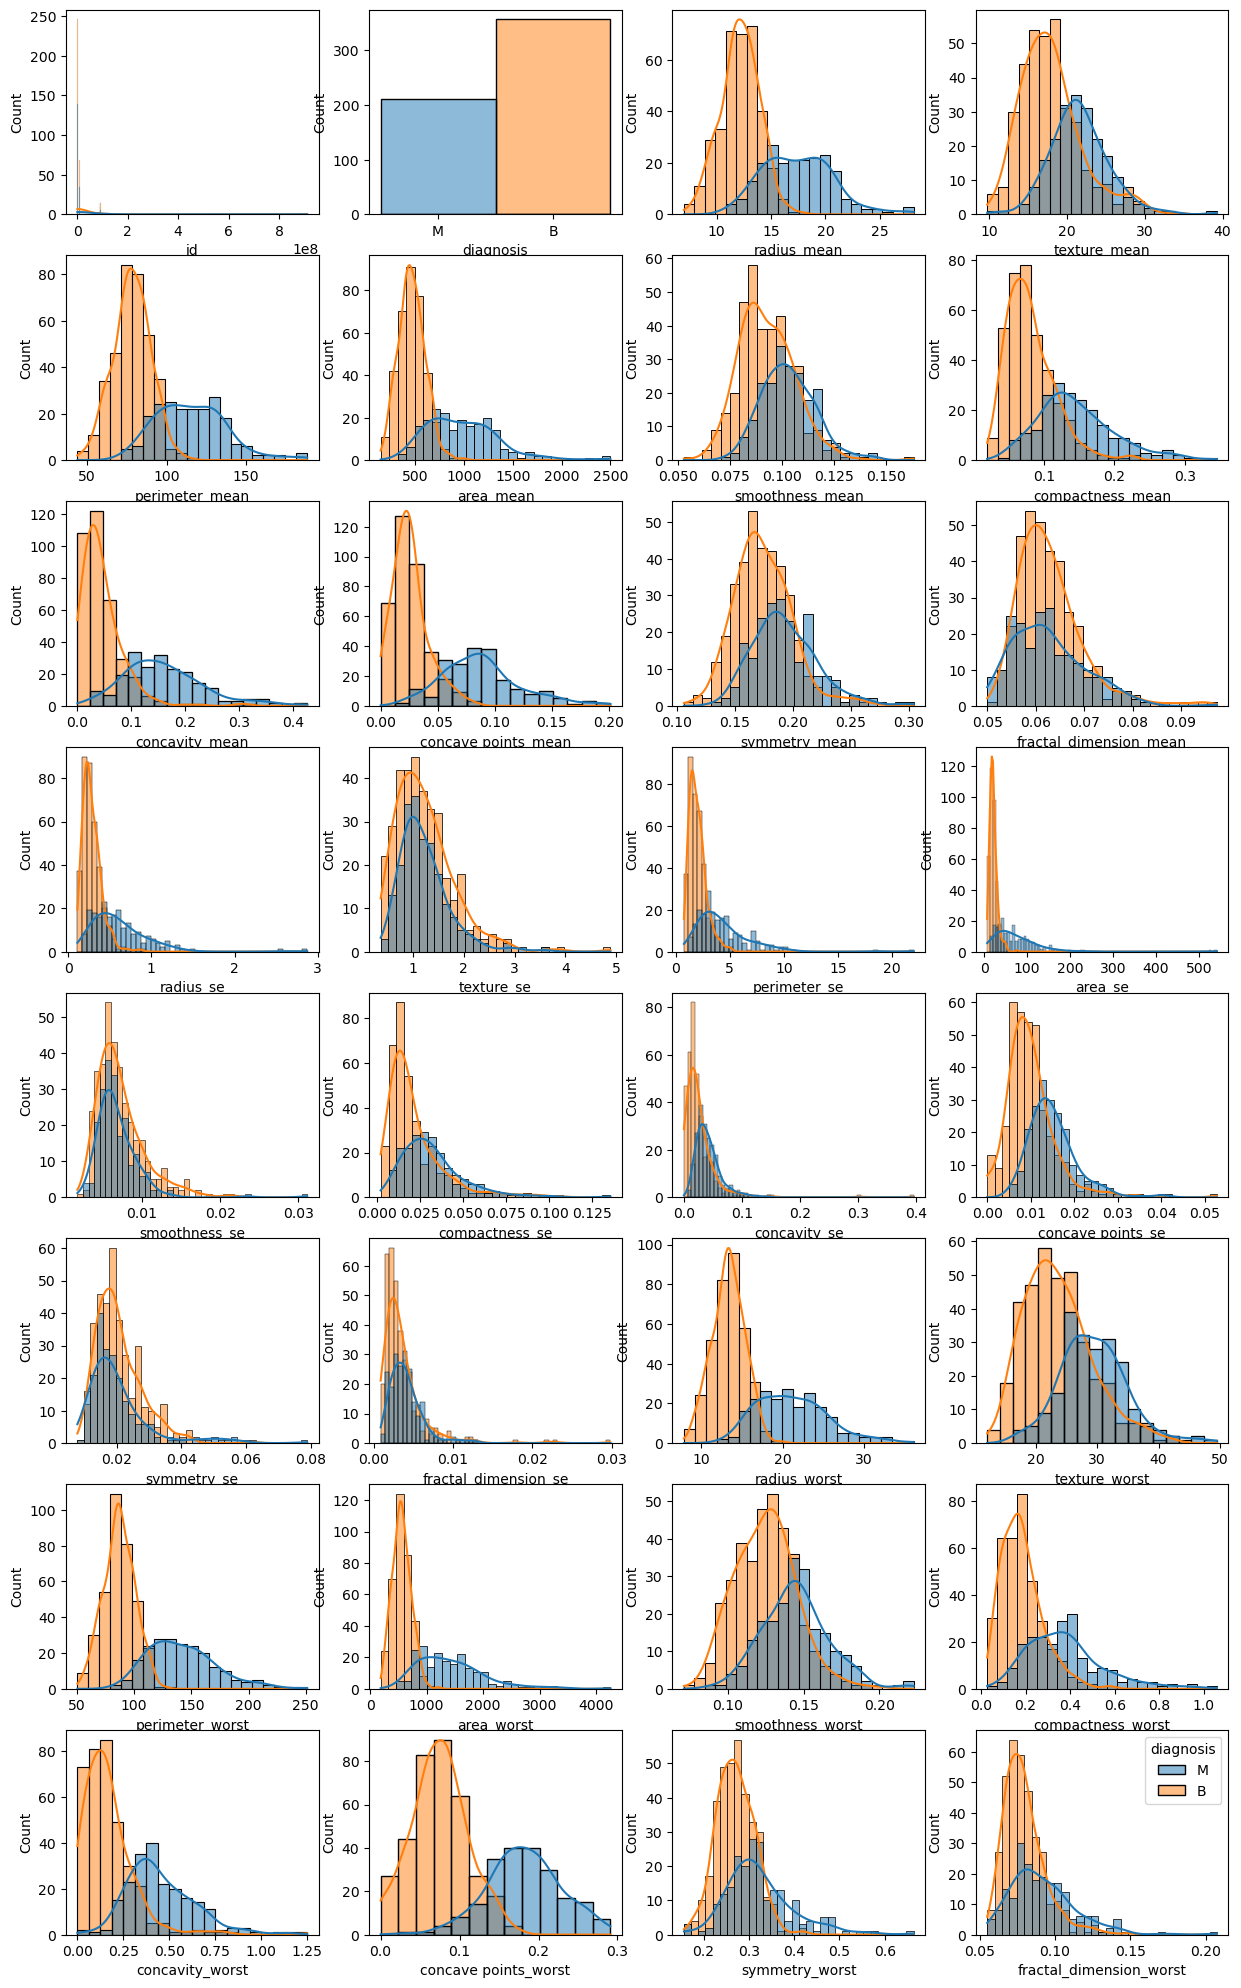

In [7]:
nCols = len(df.columns)
nRow = 8
nCol = 4
fig, ax = plt.subplots(nRow,nCol, figsize=(15,25))
ColNames = df.columns


for r in range(nRow):
    for c in range(nCol):
        i = (r*nCol) + c
        if i < nCols:
            col = ColNames[i]
            if i != nCols-1:
                sns.histplot(data=df, x=col, hue='diagnosis', kde=True, ax=ax[r,c], legend=False)
            else:
                sns.histplot(data=df, x=col, hue='diagnosis', kde=True, ax=ax[r,c], legend=True)

So we can begin to see some clear deliniations between the two groups. For example malign cells will be bigger meaning the values for `perimeter_worst`, `area_worst` and other size metrics show a visibly different distribution. Other features such as `fractal_dimension_mean` don't appear to have a clear difference.

As an additional point a lot of the data appears skewed. Which suggests that the data may need to be transformed. As a first pass I suggest min/max normalisation as this will be useful when evaluating models such as SVM and logistic regression as the values of each feature will be weighted equally. NB for tree based models such as light GBM, random forest etc... normalisation is not needed as only one feature is considered at a time.

Additionally there do not appear to be any extremely anomalous results `perimeter_se` and `concavity_se` are close to having extreme values but they may just be the results of a long tail so I will not discard them.

## Normalisation
I will implement a MinMaxScaler for all of these values so that they will be normalised

In [ ]:
# Normalise the dataframe
from sklearn.preprocessing import MinMaxScaler

df_num = df.drop(labels=['id','diagnosis'], axis=1)
mms = MinMaxScaler()
mms.fit(df_num)
data_norm = mms.transform(df_num)
df_norm = pd.DataFrame(data_norm, columns=mms.get_feature_names_out())
df_norm = pd.concat([df[['id','diagnosis']],df_norm], axis=1)
display(df_norm)

In [ ]:
nCols = len(df.columns)
nRow = 8
nCol = 4
fig, ax = plt.subplots(nRow,nCol, figsize=(15,25))
ColNames = df_norm.columns


for r in range(nRow):
    for c in range(nCol):
        i = (r*nCol) + c
        if i < nCols:
            col = ColNames[i]
            if i != nCols-1:
                sns.histplot(data=df_norm, x=col, hue='diagnosis', kde=True, ax=ax[r,c], legend=False)
            else:
                sns.histplot(data=df_norm, x=col, hue='diagnosis', kde=True, ax=ax[r,c], legend=True)

The MinMaxScaler has helped the data appear far more normal, and in many cases it has also helped segregate the two classes.

## Dimension reduction
This is just for a basic investigation to see how well a combination of values are at splitting the data even more. This will give an indication as to whether we can speed up the calculations even more by focussing on particular features

#### Unsupervised dimension reductions
1) PCA
2) UMAP

In [ ]:
# PCA
from sklearn.decomposition import PCA
data = df_norm.drop(labels=['id','diagnosis'], axis=1)
maxD = data.shape[1]

pca = PCA(n_components=maxD)
pca.fit(data)
VarExp = pca.explained_variance_ratio_
nDim = np.arange(1,maxD+1)

PCA_df = pd.DataFrame({'PC':np.arange(1,maxD+1),'VarianceExplained':VarExp})
PCA_df['CumulativeVarExp'] = PCA_df['VarianceExplained'].cumsum()
# Now plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(nDim, VarExp)
ax[0].set_xlabel('PC #')
ax[0].set_ylabel('Variance explained(ratio)')
ax[0].set_title('Variance explained by each PC')

ax[1].plot(nDim, PCA_df['CumulativeVarExp'])
ax[1].set_xlabel('PC #')
ax[1].set_ylabel('Cumulative Variance explained(ratio)')
ax[1].set_title('Cumulative Variance explained by each PC')
plt.title('Exploration of PCA contributions')
plt.show()
display(PCA_df)

There is a steep slope after 3 dimensions, but 2 dimensions brings out approximately 70% of the variance already meaning it should already be very informative. Lets plot it and have a look.

In [ ]:
nDim = 2
pca = PCA(n_components=nDim)
Xt = pca.fit_transform(data)
df_Xt = pd.DataFrame(Xt, columns=['PC1','PC2'])
df_Xt = pd.concat([df['diagnosis'],df_Xt], axis=1)
sns.scatterplot(data=df_Xt, x='PC1', y='PC2', hue='diagnosis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA on Breast Cancer image data set')

This is really nice. The data is naturally segregated, with a small amount of error on an overlapping section around (0,0). This means an ML solution should be viable. NB as this is already nice, I'm not going to waste time performing a UMAP. 

Furthermore,for future feature engineering investigations I will use the first 10 PCs as they explain 95% of the variance which should be more than sufficient. 

## Supervised dimension reduction
An alternative way, which can also lead to predictions is to perform supervised dimension reduction. 

### Partial least squares
My first method of choise is Partial Least Squares (PLS), which uses the target variable/feature, to create new features. This means I will need to re-code the target variable (diagnosis) into 0-benign and 1-malignant

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
df_pls = df_norm.copy()
# Re-code diagnosis
df_pls['diagnosis'] = df_pls['diagnosis'].replace(['M','B'],[1,0])

MaxFolds = 10

# Evaluate the accuracy of the regressor
temp_dict = {
    'nFolds': [],
    'nDim': [],
    'rmse': []
}
for f in range(2,MaxFolds+1):
    kf = KFold(n_splits=f, shuffle=True, random_state=42)
    for train, test in kf.split(df_pls):
        X_train = df_pls.iloc[train].drop(['id','diagnosis'], axis=1)
        X_test = df_pls.iloc[test].drop(['id','diagnosis'], axis=1)
        y_train = df_pls.iloc[train]['diagnosis']
        y_test = df_pls.iloc[test]['diagnosis']
        
        for nd in range(1,maxD):
            pls = PLSRegression(n_components=nd)
            pls.fit(X_train,y_train)
            y_pred = pls.predict(X_test)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            temp_dict['nFolds'].append(f)
            temp_dict['nDim'].append(nd)
            temp_dict['rmse'].append(rmse)

pls_results = pd.DataFrame(temp_dict)
sns.lineplot(data=pls_results, x='nDim', y='rmse', hue='nFolds')

Ok so about 9 dimensions produces the optimum result, any more than this and it doesn't improve. NB because this is just for evaluation accuracy and not classification (yet) I'm not using the F1 score but rather the predicted value which can be loosely interpreted as a probability value of it belonging to class 1 (malignant).

### Fisher's LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

df_lda = df_pls.copy()

for f in range(2,MaxFolds+1):
    kf = KFold(n_splits=f, shuffle=True, random_state=42)
    
    ExpVar = []
    RMSE = []
    
    for train, test in kf.split(df_lda):
        X_train = df_lda.iloc[train].drop(['id','diagnosis'], axis=1)
        X_test = df_lda.iloc[test].drop(['id','diagnosis'], axis=1)
        y_train = df_lda.iloc[train]['diagnosis']
        y_test = df_lda.iloc[test]['diagnosis']

        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train,y_train)
        y_pred = lda.predict_proba(X_test)[:,1]
        
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        expvar = lda.explained_variance_ratio_
        ExpVar.append(expvar)
        RMSE.append(rmse)

In [ ]:
fig, ax = plt.subplots(1,2)
# Transform full data set and compare
y_whole = lda.predict_proba(df_lda.drop(['id','diagnosis'], axis=1))[:,1]
sns.histplot(x=y_whole, hue=df['diagnosis'], ax=ax[0])
sns.boxplot(x=RMSE, ax=ax[1])
ax[0].set_xlabel('Prediction Probability')
ax[0].set_title('FDA on whole data set')

ax[1].set_xlabel('RMSE')
ax[1].set_title('Accuracy of Prediction')

In fact it seems Fischers DA actually performs better the PLS in predicting the values. However, let's see if after hyper-parameter tuning it will be better.

# Model Selection
## The aim now is to try and test out various ML solutions to produce the best result
* Fischer DA
* PLS-DA
* RandomForest
* XGBoost
* LightGBM
* SVM
* Logistic Regression

As a reminder I will optimise based on the F1 score, but I will create a dictionary where its optimum parameters, F1 score and columns used are stored. This means I will score the feature importances separately.

Additionally I will also try this on the first 10 PC features, this may also improve the speed of the algorithm

## Do a train-test-val split
The first step is to keep a validation data set separate for final comparison of all the optimised models. The train-test split will be done with k-folds=5 on the training data so I will not bother doing the train-test-val split. I will just do train-val.

NB I will also assess this for the 10 feature engineered PCs from PCA.

In [ ]:
from sklearn.model_selection import train_test_split
X = df_norm.drop(labels=['id','diagnosis'], axis=1)
y = df_norm['diagnosis'].replace(['M','B'],[1,0])

#Perform PCA
pca = PCA(n_components=10)
Xpca = pca.fit_transform(X)
Xpca = pd.DataFrame(Xpca, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

#Train validation splits
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
Xpca_train, Xpca_val, ypca_train, ypca_val = train_test_split(Xpca, y, test_size=0.2, random_state=42)

print("Train size: ",X_train.shape)
print("Validation size: ",X_val.shape)

## Fischer DA

In [ ]:
# From direct features
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#Set up a dictionary to store information about models
Model_dict = {
    'Model': [],
    'PCA': [],
    'F1_Score': [],
    'Parameters': [],
    'Time': []
}

Param_Grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage': np.arange(0,1,0.1),
              'tol': np.arange(0,0.001,0.0001)
             }

lda = LinearDiscriminantAnalysis()

Grid_Search = GridSearchCV(
    estimator = lda,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(X_train,y_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
LDA_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')

for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(X_val)
print (classification_report(y_val, y_pred))

#Add in Fischer/LinearDiscriminant model
Model_dict['Model'].append('LinearDiscriminantAnalysis')
Model_dict['PCA'].append('n')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

In [ ]:
#Engineered Features
lda = LinearDiscriminantAnalysis()

Grid_Search = GridSearchCV(
    estimator = lda,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(Xpca_train,ypca_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
LDApca_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')

for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(Xpca_val)
print (classification_report(y_val, y_pred))

#Add in Fischer/LinearDiscriminant model
Model_dict['Model'].append('LinearDiscriminantAnalysis')
Model_dict['PCA'].append('y')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

## PLS
For PLS-DA there isn't a plug and play version that works with an F1 score calculation in grid search so I've written it myself


In [ ]:
#Will have to write my own grid search for PLS because the DA part isn't accomodated in the pipeline
#No feature engineering
scores_dict = {
    'n_components': [],
    'scale': [],
    'max_iter': [],
    'DA_Threshold': [],
    'F1_score': []
}
Components = np.arange(1,15)
Scales = [True, False]
max_iter = [5, 10, 20]
Thresh = np.arange(0.25,0.75,0.05)
for nd in Components:
    for s in Scales:
        for mi in max_iter:
            pls = PLSRegression(n_components=nd, scale = s, max_iter=mi)
            kf = KFold(n_splits=5)
            f1s = []
            for th in Thresh:
                for train, test in kf.split(Xpca_train):
                    #Get the train-test splits per fold
                    X_tr = X_train.iloc[train]
                    X_te = X_train.iloc[test]
                    y_tr = y_train.iloc[train]
                    y_te = y_train.iloc[test]

                    pls.fit(X_tr,y_tr)
                    y_pred = pls.predict(X_te)
                    y_final = y_pred >= th
                    y_final = y_final*1
                    f1s.append(f1_score(y_te,y_final))
                f1m = np.mean(f1s)
                scores_dict['n_components'].append(nd)
                scores_dict['scale'].append(s)
                scores_dict['max_iter'].append(mi)
                scores_dict['DA_Threshold'].append(th)
                scores_dict['F1_score'].append(f1m)
                    
pls_score_df = pd.DataFrame(scores_dict)
max_idx = pls_score_df['F1_score'].argmax()
display(pls_score_df.iloc[max_idx])

p = {'n_components': pls_score_df.iloc[max_idx]['n_components'],
    'scale': pls_score_df.iloc[max_idx]['scale'],
    'max_iter': pls_score_df.iloc[max_idx]['max_iter'],
    'DA_Threshold': pls_score_df.iloc[max_idx]['DA_Threshold']
    }
PLS_DA_Params = p

#Add in PLS model
Model_dict['Model'].append('PLS-DA')
Model_dict['PCA'].append('n')
Model_dict['F1_Score'].append(pls_score_df.iloc[max_idx]['F1_score'])
Model_dict['Parameters'].append(p)

#Calculate the time to fit the whole data
import time
start = time.time()
pls = PLSRegression(n_components=p['n_components'], scale = p['scale'], max_iter=p['max_iter'])
pls.fit(X_train,y_train)
y_final = y_pred >= p['DA_Threshold']
y_final = y_final*1
end = time.time()

Model_dict['Time'].append(end-start)

In [ ]:
#Feature Engineered
scores_dict = {
    'n_components': [],
    'scale': [],
    'max_iter': [],
    'DA_Threshold': [],
    'F1_score': []
}
Components = np.arange(1,10)
Scales = [True, False]
max_iter = [5, 10, 20]
Thresh = np.arange(0.25,0.75,0.05)
for nd in Components:
    for s in Scales:
        for mi in max_iter:
            pls = PLSRegression(n_components=nd, scale = s, max_iter=mi)
            kf = KFold(n_splits=5)
            f1s = []
            for th in Thresh:
                for train, test in kf.split(Xpca_train):
                    #Get the train-test splits per fold
                    X_tr = Xpca_train.iloc[train]
                    X_te = Xpca_train.iloc[test]
                    y_tr = ypca_train.iloc[train]
                    y_te = ypca_train.iloc[test]

                    pls.fit(X_tr,y_tr)
                    y_pred = pls.predict(X_te)
                    y_final = y_pred >= th
                    y_final = y_final*1
                    f1s.append(f1_score(y_te,y_final))
                f1m = np.mean(f1s)
                scores_dict['n_components'].append(nd)
                scores_dict['scale'].append(s)
                scores_dict['max_iter'].append(mi)
                scores_dict['DA_Threshold'].append(th)
                scores_dict['F1_score'].append(f1m)
                    
pls_score_df = pd.DataFrame(scores_dict)
max_idx = pls_score_df['F1_score'].argmax()
display(pls_score_df.iloc[max_idx])

p_pca = {'n_components': pls_score_df.iloc[max_idx]['n_components'],
    'scale': pls_score_df.iloc[max_idx]['scale'],
    'max_iter': pls_score_df.iloc[max_idx]['max_iter'],
    'DA_Threshold': pls_score_df.iloc[max_idx]['DA_Threshold']
    }
PLS_DApca_Params = p_pca

#Add in PLS model
Model_dict['Model'].append('PLS-DA')
Model_dict['PCA'].append('y')
Model_dict['F1_Score'].append(pls_score_df.iloc[max_idx]['F1_score'])
Model_dict['Parameters'].append(p)

#Calculate the time to fit the whole data
import time
start = time.time()
pls = PLSRegression(n_components=p['n_components'], scale = p['scale'], max_iter=p['max_iter'])
pls.fit(X_train,y_train)
y_final = y_pred >= p['DA_Threshold']
y_final = y_final*1
end = time.time()

Model_dict['Time'].append(end-start)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#No Feature Engineering    
Param_Grid = {'n_estimators': [10, 20, 30],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [40, 50, 75],
              'min_samples_leaf': [1],
              'max_features' : [None]
             }

rfc = RandomForestClassifier()

Grid_Search = GridSearchCV(
    estimator = rfc,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(X_train,y_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
RFC_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')
for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(X_val)
print (classification_report(y_val, y_pred))

#Add in Random Forest model
Model_dict['Model'].append('Random Forest Classifier')
Model_dict['PCA'].append('n')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

In [ ]:
#Feature Engineering    
rfc = RandomForestClassifier()

Grid_Search = GridSearchCV(
    estimator = rfc,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(Xpca_train,ypca_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
RFCpca_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')

for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(Xpca_val)
print (classification_report(ypca_val, y_pred))

#Add in Random Forest model
Model_dict['Model'].append('Random Forest Classifier')
Model_dict['PCA'].append('y')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

### XGBoost

In [ ]:
from xgboost import XGBClassifier
    
Param_Grid = {'max_depth': [2, 5, 10, 25],
              'learning_rate': [0.04, 0.05, 0.06, 0.1],
              'n_estimators': [400, 500, 600],
              'gamma' : [0],
              'min_child_weight': [0.01, 0.1, 0.2]
             }
#No feature engineering
xgb = XGBClassifier()

Grid_Search = GridSearchCV(
    estimator = xgb,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(X_train,y_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
XGB_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')
for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(X_val)
print (classification_report(y_val, y_pred))
#Add in XGB model
Model_dict['Model'].append('XGBoost Classifier')
Model_dict['PCA'].append('n')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

In [ ]:
xgb = XGBClassifier()

Grid_Search = GridSearchCV(
    estimator = xgb,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(Xpca_train,ypca_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
XGBpca_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')
for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(Xpca_val)
print (classification_report(ypca_val, y_pred))
#Add in XGB model
Model_dict['Model'].append('XGBoost Classifier')
Model_dict['PCA'].append('y')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

### Light GBM

In [ ]:
import lightgbm as LGB
#from lightgbm import LGBMClassifier
    
Param_Grid = {'boosting_type': ['gbdt'],
              'num_leaves': [10, 20, 31, 40, 50],
              'learning_rate': [0.025, 0.05],
              'n_estimators': [100, 400, 500, 600],
              'min_child_samples': [1, 5, 10]
             }                         
                                                  
lgb = LGB.LGBMClassifier(objective='binary', random_state=42, max_depth=-1)

Grid_Search = GridSearchCV(
    estimator = lgb,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(X_train,y_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
LGB_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')

for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(X_val)
print (classification_report(y_val, y_pred))

#Add in LGB model`
Model_dict['Model'].append('LightGBM Classifier')
Model_dict['PCA'].append('n')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

In [ ]:
lgb = LGB.LGBMClassifier(objective='binary', random_state=42, max_depth=-1)

Grid_Search = GridSearchCV(
    estimator = lgb,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(Xpca_train,ypca_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
LGBpca_Params = Best_Parameters
print (f'Best score: {np.round(Grid_Search.best_score_,4)}')

for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(Xpca_val)
print (classification_report(ypca_val, y_pred))

#Add in LGB model`
Model_dict['Model'].append('LightGBM Classifier')
Model_dict['PCA'].append('y')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
Param_Grid = {'C': [0.5, 0.75, 1, 1.25, 2],
              'kernel': ['rbf'],
              'gamma': ['scale']
             }

svc = SVC(random_state=42)

Grid_Search = GridSearchCV(
    estimator = svc,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(X_train,y_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
SVC_Params = Best_Parameters

print (f'Best score: {np.round(Grid_Search.best_score_,4)}')
for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(X_val)
print (classification_report(y_val, y_pred))

#Add in SVC model
Model_dict['Model'].append('Support Vector Classifier')
Model_dict['PCA'].append('n')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

In [ ]:
svc = SVC(random_state=42)

Grid_Search = GridSearchCV(
    estimator = svc,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
Grid_Search.fit(Xpca_train,ypca_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
SVCpca_Params = Best_Parameters

print (f'Best score: {np.round(Grid_Search.best_score_,4)}')
for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(Xpca_val)
print (classification_report(ypca_val, y_pred))

#Add in SVC model
Model_dict['Model'].append('Support Vector Classifier')
Model_dict['PCA'].append('y')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

### Logistic Regressor

In [ ]:
from sklearn.linear_model import LogisticRegression
Param_Grid = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [0.0001, 0.001, 0.005],
              'solver': ['lbfgs', 'liblinear'],
              'max_iter': [25, 50, 100, 150]
             }

lrc = LogisticRegression(random_state=42, multi_class='ovr')

Grid_Search = GridSearchCV(
    estimator = lrc,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
    
Grid_Search.fit(X_train,y_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
LR_Params = Best_Parameters

print (f'Best score: {np.round(Grid_Search.best_score_,4)}')
for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(X_val)
print (classification_report(y_val, y_pred))

#Add in Logistic regression model
Model_dict['Model'].append('Logistic Regression Classifier')
Model_dict['PCA'].append('n')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

In [ ]:
lrc = LogisticRegression(random_state=42, multi_class='ovr')

Grid_Search = GridSearchCV(
    estimator = lrc,
    param_grid = Param_Grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'f1',
    verbose = 1
)
    
Grid_Search.fit(Xpca_train,ypca_train)
Best_Parameters = Grid_Search.best_estimator_.get_params()
LRpca_Params = Best_Parameters

print ('Best score: %0.3f', Grid_Search.best_score_)
print ('Best parameters set:', Best_Parameters )
for Param_Name in sorted(Param_Grid.keys()):
    print ('\t%s: %r' %(Param_Name, Best_Parameters[Param_Name]))

y_pred = Grid_Search.predict(Xpca_val)
print (classification_report(ypca_val, y_pred))

#Add in Logistic regression model
Model_dict['Model'].append('Logistic Regression Classifier')
Model_dict['PCA'].append('y')
Model_dict['F1_Score'].append(Grid_Search.best_score_)
Model_dict['Parameters'].append(Best_Parameters)
Model_dict['Time'].append(Grid_Search.refit_time_)

In [ ]:
# Evaluate the models on the validation set
Model_Val={'Model':[],'F1_Score':[]}
#LDA
lda = LinearDiscriminantAnalysis(**LDA_Params)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('LinearDiscriminantAnalysis')
Model_Val['F1_Score'].append(f1)

lda = LinearDiscriminantAnalysis(**LDApca_Params)
lda.fit(Xpca_train, ypca_train)
y_pred = lda.predict(Xpca_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('LinearDiscriminantAnalysis_PCA')
Model_Val['F1_Score'].append(f1)

#PLS-DA
pls = PLSRegression(n_components=PLS_DA_Params['n_components'], 
                    scale = PLS_DA_Params['scale'], 
                    max_iter=PLS_DA_Params['max_iter'])
pls.fit(X_train,y_train)
y_pred = pls.predict(X_val)
y_final = y_pred >= th
y_final = y_final*1
f1 = f1_score(y_val,y_final)
Model_Val['Model'].append('PLS-DA')
Model_Val['F1_Score'].append(f1)

pls = PLSRegression(n_components=PLS_DApca_Params['n_components'], 
                    scale = PLS_DApca_Params['scale'], 
                    max_iter=PLS_DApca_Params['max_iter'])
pls.fit(Xpca_train,ypca_train)
y_pred = pls.predict(Xpca_val)
y_final = y_pred >= th
y_final = y_final*1
f1 = f1_score(y_val,y_final)
Model_Val['Model'].append('PLS-DA_PCA')
Model_Val['F1_Score'].append(f1)


#Random Forest Classifier
rfc = RandomForestClassifier(**RFC_Params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('Random Forest')
Model_Val['F1_Score'].append(f1)

rfc = RandomForestClassifier(**RFCpca_Params)
rfc.fit(Xpca_train, ypca_train)
y_pred = rfc.predict(Xpca_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('Random Forest_PCA')
Model_Val['F1_Score'].append(f1)

#XGBoost
xgb = XGBClassifier(**XGB_Params)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('XGBoost')
Model_Val['F1_Score'].append(f1)

xgb = XGBClassifier(**XGBpca_Params)
xgb.fit(Xpca_train,ypca_train)
y_pred = xgb.predict(Xpca_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('XGBoost_PCA')
Model_Val['F1_Score'].append(f1)

#LightGB
lgb = LGB.LGBMClassifier(**LGB_Params)
lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('LGBM')
Model_Val['F1_Score'].append(f1)

lgb = LGB.LGBMClassifier(**LGBpca_Params)
lgb.fit(Xpca_train,ypca_train)
y_pred = lgb.predict(Xpca_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('LGBM_PCA')
Model_Val['F1_Score'].append(f1)

#Support Vector Classifier
svc = SVC(**SVC_Params)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('SVC')
Model_Val['F1_Score'].append(f1)

svc = SVC(**SVCpca_Params)
svc.fit(Xpca_train,ypca_train)
y_pred = svc.predict(Xpca_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('SVC_PCA')
Model_Val['F1_Score'].append(f1)

#Logistic Regression Classifier
lrc = LogisticRegression(**LR_Params)
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('LogRegressor')
Model_Val['F1_Score'].append(f1)

lrc = LogisticRegression(**LRpca_Params)
lrc.fit(Xpca_train,ypca_train)
y_pred = lrc.predict(Xpca_val)
f1 = f1_score(y_val,y_pred)
Model_Val['Model'].append('LogRegressor_PCA')
Model_Val['F1_Score'].append(f1)

In [ ]:
# Now plot the results
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.barplot(data = Model_dict, x = 'Model', y = 'F1_Score', hue='PCA', ax=ax[0])
ax[0].set_ylim(0.8,1)
ax[0].set_title('On training data')
sns.barplot(data = Model_Val, x = 'Model',y = 'F1_Score', ax=ax[1])
ax[1].set_ylim(0.8,1)
ax[1].set_title('On validation data')

display(pd.DataFrame(Model_Val))

Our two best models are the Random Forest classifier on the PCA data, or the two Logistic regression models. With the LogRegressor values having an F1 score of almost 0.99. Therefore the ultimate question is which one can be implemented faster. I.e. I will now look at the speed of processing

In [ ]:
display(pd.DataFrame(Model_dict))

Ok by far the fastest is the logistic regression classifier after PCA. With a speed of 7 thousandths of a second so I will pick this to investigate.

# Feature selection
The logistic regression classifier works best. However, I also want to see which are the required features and which ones just add noise to the system.

In [ ]:
np.random.seed(42)
Xpca_train['random_feature'] = np.random.rand(Xpca_train.shape[0])
lrc = LogisticRegression(**LR_Params)
lrc.fit(Xpca_train,ypca_train)
coefficients = lrc.coef_[0]

feature_importance = pd.DataFrame({'Feature': Xpca_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

It appears that all features apart from `PC6` is important, but I estimate that the coding for this will slow it down significantly. So I will keep `PC6` within the model.

Now the aim is to sum up all the steps into one single step

# Final Evaluation

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

# Step 1 extract the key fields only
X = df.drop(labels=['id','diagnosis'], axis=1)
y = df['diagnosis']

# Step 2 apply a min-max scaler, and transform y
mms = MinMaxScaler()
mms.fit(X)
X_norm = mms.transform(X)

y = y.replace(['M','B'],[1,0])

#Step 3 train-test split
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#Step 4 perform PCA for 10 dimensions
pca = PCA(n_components=10)
Xtr = pca.fit_transform(X_train)
Xte = pca.transform(X_val)

ColNames = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
X_train = pd.DataFrame(Xtr, columns=ColNames)
X_val = pd.DataFrame(Xte, columns=ColNames )

# Step 5 train the model
lrc = LogisticRegression(**LRpca_Params)
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_val)
y_probs = lrc.predict_proba(X_val)[:,1]

# Step 5 predict and plot a precision recall curve
# fig, ax = plt.subplots(1,2, figsize=(10,5))
# ax[0] = PrecisionRecallDisplay.from_predictions(y_val, y_pred, name="Logistic Regression")
# ax[0].set_title("2-class Precision-Recall curve")
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

In [ ]:
ax = sns.lineplot(x=precision, y=recall)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision Recall Curve for a logistic regression classifier')

In [ ]:
print(LR_Params)

So to conclude the best solution is...
1. Normalise the data with a MinMaxScaler
2. Apply a 10 dimensional PCA
3. A logistic regression classifier, the parameters as above

# Saving outputs
What I will need to do....
* Using pickle, save a file with
    1. the MinMaxScaler
    2. the PCA at 10 dimensions
    3. the LogisticRegressionClassifier
* Write a .py file to train the model

## Create train.py (in order to save a pickle using the data.csv file)


In [ ]:
### Libraries Needed 
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

### Input Variables
data_file = "data.csv"
Model_Params = {
    'class_weight': None, 
    'dual': False, 
    'fit_intercept': True, 
    'intercept_scaling': 1,
    'max_iter': 200, #Increased from the 15 to stop a warning 
    'multi_class': 'ovr', 
    'n_jobs': None, 
    'penalty': None, 
    'random_state': 42, 
    'solver': 'lbfgs', 
    'tol': 0.0001, 
    'verbose': 0, 
    'warm_start': False
} #NB because no penalty C and L1_ratio are not needed
ModelFileName = 'model.bin'

## Load the whole dataset
print('Reading in training data...')
df = pd.read_csv(data_file)
## Split into variables
X = df.drop(labels=['id','diagnosis','Unnamed: 32'], axis=1)
y = df['diagnosis'].replace(['M','B'],[1,0])

print('Scaling data...')
## MinMaxScaler
mms = MinMaxScaler()
mms.fit(X)
X_norm = mms.transform(X)

## PCA
print('Performing dimension reduction...')
pca = PCA(n_components=10)
Xt = pca.fit_transform(X_norm)

## Get some stats about the fit by doing K-Folds
print('Evaluating model performance...')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = np.zeros(5)
c = 0
for train, test in kf.split(Xt):
    X_train = Xt[train,:]
    X_test = Xt[test,:]
    y_train = y[train]
    y_test = y[test]
    
    lrc = LogisticRegression(**Model_Params)
    lrc.fit(X_train,y_train)
    y_pred = lrc.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    f1_scores[c] = f1
    result = f'Fold Number: {c+1}, F1 score: {np.round(f1,4)}'
    print(result)
    c += 1
result = f'Mean F1 Score: {np.mean(f1_scores)}'
print(result)
      
## Now train the final model
print('Training final model...')
lrc = LogisticRegression(**Model_Params)
lrc.fit(Xt,y)

print('Saving final model...')
with open(ModelFileName, 'wb') as f_out: # 'wb' means write-binary
    pickle.dump((mms, pca, lrc, Model_Params), f_out)

print('Model saved.')

In [ ]:
df.columns

### Run saved model

In [5]:
import pickle
import pandas as pd

with open('model.bin', 'rb') as f_in: # very important to use 'rb' here, it means read-binary 
    mms, pca, lrc, LRpca_Params = pickle.load(f_in)

In [6]:
cell = {
    'radius_mean': 17.99,
    'texture_mean': 10.38,
    'perimeter_mean': 122.80, 
    'area_mean': 1001.0,
    'smoothness_mean': 0.11840,
    'compactness_mean': 0.27760,
    'concavity_mean': 0.30010, 
    'concave points_mean': 0.14710,
    'symmetry_mean': 0.2419,
    'fractal_dimension_mean': 0.07871,
    'radius_se':  1.095,
    'texture_se': 0.9053,
    'perimeter_se': 8.589,
    'area_se': 153.4,
    'smoothness_se': 0.006399,
    'compactness_se': 0.04904,
    'concavity_se': 0.05373,
    'concave points_se': 0.0158,
    'symmetry_se':  0.03003,
    'fractal_dimension_se': 0.006193,
    'radius_worst': 25.38,
    'texture_worst': 17.33,
    'perimeter_worst': 184.6,
    'area_worst': 2019.0,
    'smoothness_worst': 0.1622,
    'compactness_worst': 0.6656,
    'concavity_worst': 0.7119,
    'concave points_worst': 0.2654,
    'symmetry_worst': 0.4601,
    'fractal_dimension_worst': 0.11890
}

In [7]:
# Predict function
def transform_data(cell):
    df_X = pd.DataFrame(cell, index=[0])
    iX = mms.transform(df_X)
    X = pca.transform(iX)
    return X

def predict_from_model(X):
    y_pred = lrc.predict_proba(X)[0,1]
    if y_pred >= 0.5:
        Diagnosis = "Malignant"
    else:
        Diagnosis = "Benign"
    return Diagnosis, y_pred
            
X = transform_data(cell)
Diagnosis, y_pred = predict_from_model(X)
text = f"Cell Diagnosis: {Diagnosis}\np Malignant: {y_pred}"
print(text)

Cell Diagnosis: Malignant
p Malignant: 0.9999999999998272
